# Overview

### Target 
1. Regularization (BatchNormalization, Dropout)

### Result 
1. Parameters: 9,680
2. Best Training Accuracy: 99.31
3. Best Test Accuracy: 99.32

### Analysis 
1. Model is no longer overfitting, but not reaching goal accuracy. 


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import matplotlib.pyplot as plt

# Data Transformations


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model


In [6]:
dropout_value = 0.1
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),nn.Dropout(dropout_value)
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),nn.Dropout(dropout_value)
    )

    self.pool1 = nn.Sequential(
        nn.MaxPool2d(2, 2)
    )

    # Convolution Block 3
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),nn.Dropout(dropout_value)
    )

    # Convolution Block 4
    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),nn.Dropout(dropout_value)
    )

    # Convolution Block 5
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),nn.Dropout(dropout_value)
    )

    # Global average pooling layer
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),padding = 0, bias = False)
    )
  
  def forward(self, x):

    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)

    x = self.convblock3(x)
    x = self.convblock4(x)    
    x = self.convblock5(x)
    
    x = self.gap(x)
    x = x.view(-1,10)
    
    return F.log_softmax(x,dim = -1)


# Model Parameters

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,304
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_losses.append(loss)
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.08476141095161438 Batch_id=468 Accuracy=87.36: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]



Test set: Average loss: 0.0884, Accuracy: 9781/10000 (97.81%)

EPOCH: 1


Loss=0.07409297674894333 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]



Test set: Average loss: 0.0536, Accuracy: 9852/10000 (98.52%)

EPOCH: 2


Loss=0.07574380189180374 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]



Test set: Average loss: 0.0416, Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Loss=0.042152151465415955 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]



Test set: Average loss: 0.0339, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.020197978243231773 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]



Test set: Average loss: 0.0332, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.10118909925222397 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]



Test set: Average loss: 0.0312, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.021955901756882668 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]



Test set: Average loss: 0.0285, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.024944156408309937 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]



Test set: Average loss: 0.0264, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.021722659468650818 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]



Test set: Average loss: 0.0247, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.008303829468786716 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]



Test set: Average loss: 0.0239, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.03359488025307655 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]



Test set: Average loss: 0.0255, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.0065315295942127705 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0238, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=0.03160499036312103 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]



Test set: Average loss: 0.0259, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.019273409619927406 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]



Test set: Average loss: 0.0223, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.01050479244440794 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]



Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.015711406245827675 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]



Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.06014014407992363 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]



Test set: Average loss: 0.0257, Accuracy: 9917/10000 (99.17%)

EPOCH: 17


Loss=0.003921970259398222 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]



Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.024156900122761726 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]



Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.010904032737016678 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]



Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)



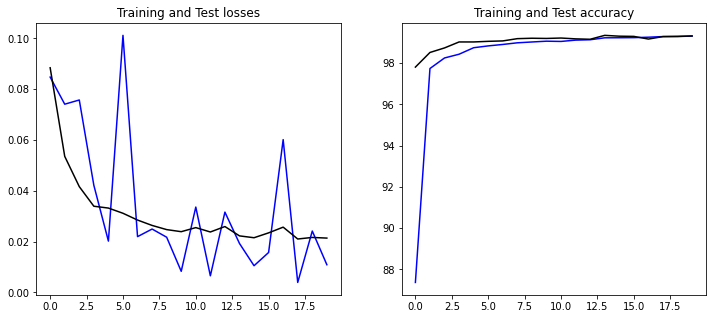

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(train_losses, c='blue')
ax1.plot(test_losses, c='black')
ax1.title.set_text('Training and Test losses')

ax2.plot(train_acc, c='blue')
ax2.plot(test_acc, c='black')
ax2.title.set_text('Training and Test accuracy')